In [1]:
import os
import shutil
import random
from pathlib import Path
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import models, layers, optimizers

2025-04-15 19:11:23.575786: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 19:11:23.618418: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-15 19:11:23.618460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-15 19:11:23.620086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-15 19:11:23.627929: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 19:11:23.628317: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
img_height, img_width = 150, 150
batch_size = 32

In [3]:
random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Reproduceable Randoms

In [4]:
data_dir = "data"
damage_path = os.path.join(data_dir, "damage")
no_damage_path = os.path.join(data_dir, "no_damage")

In [5]:
print(f"Damaged images count: {len(os.listdir(damage_path))}")
print(f"No-damage images count: {len(os.listdir(no_damage_path))}")

Damaged images count: 14170
No-damage images count: 7152


In [6]:
split_dir = "data/split"
try:
    shutil.rmtree(split_dir)
except:
    pass

In [7]:
Path(f"{split_dir}/train/damage").mkdir(parents=True, exist_ok=True)
Path(f"{split_dir}/train/no_damage").mkdir(parents=True, exist_ok=True)
Path(f"{split_dir}/val/damage").mkdir(parents=True, exist_ok=True)
Path(f"{split_dir}/val/no_damage").mkdir(parents=True, exist_ok=True)
Path(f"{split_dir}/test/damage").mkdir(parents=True, exist_ok=True)
Path(f"{split_dir}/test/no_damage").mkdir(parents=True, exist_ok=True)

In [8]:
image_extensions = ('.jpg', '.jpeg')

damage_files = [
    f for f in os.listdir(damage_path)
    if f.lower().endswith(image_extensions) and os.path.isfile(os.path.join(damage_path, f))
]

no_damage_files = [
    f for f in os.listdir(no_damage_path)
    if f.lower().endswith(image_extensions) and os.path.isfile(os.path.join(no_damage_path, f))
]

In [9]:
random.shuffle(damage_files)
random.shuffle(no_damage_files)

In [11]:
damage_train_end = int(0.7 * len(damage_files))
damage_val_end = damage_train_end + int(0.15 * len(damage_files))

In [12]:
damage_train = damage_files[:damage_train_end]
damage_val = damage_files[damage_train_end:damage_val_end]
damage_test = damage_files[damage_val_end:]

In [13]:
no_damage_train_end = int(0.7 * len(no_damage_files))
no_damage_val_end = no_damage_train_end + int(0.15 * len(no_damage_files))

In [14]:
no_damage_train = no_damage_files[:no_damage_train_end]
no_damage_val = no_damage_files[no_damage_train_end:no_damage_val_end]
no_damage_test = no_damage_files[no_damage_val_end:]

In [15]:
for file in damage_train:
    shutil.copyfile(os.path.join(damage_path, file),
                   os.path.join(split_dir, "train/damage", file))

for file in damage_val:
    shutil.copyfile(os.path.join(damage_path, file),
                   os.path.join(split_dir, "val/damage", file))

for file in damage_test:
    shutil.copyfile(os.path.join(damage_path, file),
                   os.path.join(split_dir, "test/damage", file))

# No Damage - Train, Val, Test
for file in no_damage_train:
    shutil.copyfile(os.path.join(no_damage_path, file),
                   os.path.join(split_dir, "train/no_damage", file))

for file in no_damage_val:
    shutil.copyfile(os.path.join(no_damage_path, file),
                   os.path.join(split_dir, "val/no_damage", file))

for file in no_damage_test:
    shutil.copyfile(os.path.join(no_damage_path, file),
                   os.path.join(split_dir, "test/no_damage", file))

In [16]:
print(f"Train - Damage: {len(damage_train)}, No-damage: {len(no_damage_train)}")
print(f"Val - Damage: {len(damage_val)}, No-damage: {len(no_damage_val)}")
print(f"Test - Damage: {len(damage_test)}, No-damage: {len(no_damage_test)}")

Train - Damage: 9919, No-damage: 5006
Val - Damage: 2125, No-damage: 1072
Test - Damage: 2126, No-damage: 1074


In [17]:
total_damage = len(damage_files)
total_no_damage = len(no_damage_files)
total = total_damage + total_no_damage

In [18]:
weight_for_0 = (1 / total_damage) * (total / 2) 
weight_for_1 = (1 / total_no_damage) * (total / 2)

In [19]:
class_weight = {0: weight_for_0, 1: weight_for_1}
print(f"Class weights - Damage: {weight_for_0:.4f}, No-damage: {weight_for_1:.4f}")

Class weights - Damage: 0.7524, No-damage: 1.4906


In [20]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{split_dir}/train",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 14925 files belonging to 2 classes.


In [22]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{split_dir}/test",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3200 files belonging to 2 classes.


In [23]:
class_names = train_ds.class_names
print("\nClass names:", class_names)


Class names: ['damage', 'no_damage']


In [24]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

In [25]:
rescale = Rescaling(scale=1./255)

In [26]:
def augment_and_rescale_train(x, y):
    x = data_augmentation(x)
    return rescale(x), y

In [27]:
train_ds = train_ds.map(augment_and_rescale_train)
val_ds = val_ds.map(lambda x, y: (rescale(x), y))
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

In [28]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [30]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
        
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [31]:
best_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [32]:
model_dense = models.Sequential()
model_dense.add(layers.Flatten(input_shape=(150, 150, 3)))
model_dense.add(layers.Dense(256, activation='relu'))
model_dense.add(layers.Dropout(0.5))
model_dense.add(layers.Dense(128, activation='relu'))
model_dense.add(layers.Dropout(0.3))
model_dense.add(layers.Dense(1, activation='sigmoid'))

In [33]:
model_dense.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [34]:
history_dense = model_dense.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[early_stopping, lr_scheduler, tf.keras.callbacks.ModelCheckpoint(
        'best_dense_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )]
)

Epoch 1/5
467/467 [==============================] - ETA: 0s - loss: 0.7446 - accuracy: 0.4879 - auc: 0.5065 - precision: 0.3345 - recall: 0.5324
Epoch 1: val_loss improved from inf to 0.69328, saving model to best_dense_model.h5


/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


467/467 [==============================] - 68s 144ms/step - loss: 0.7446 - accuracy: 0.4879 - auc: 0.5065 - precision: 0.3345 - recall: 0.5324 - val_loss: 0.6933 - val_accuracy: 0.3356 - val_auc: 0.5002 - val_precision: 0.3354 - val_recall: 1.0000 - lr: 1.0000e-04
Epoch 2/5
467/467 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.4155 - auc: 0.5015 - precision: 0.3341 - recall: 0.7475
Epoch 2: val_loss did not improve from 0.69328
467/467 [==============================] - 66s 141ms/step - loss: 0.6939 - accuracy: 0.4155 - auc: 0.5015 - precision: 0.3341 - recall: 0.7475 - val_loss: 0.6933 - val_accuracy: 0.3353 - val_auc: 0.5000 - val_precision: 0.3353 - val_recall: 1.0000 - lr: 1.0000e-04
Epoch 3/5
467/467 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.4564 - auc: 0.5000 - precision: 0.3304 - recall: 0.6047
Epoch 3: val_loss improved from 0.69328 to 0.69319, saving model to best_dense_model.h5
467/467 [==============================] - 

In [35]:
best_dense_model = tf.keras.models.load_model('best_dense_model.h5')
test_metrics_dense = best_dense_model.evaluate(test_ds, return_dict=True)
print("\nDense ANN Test Metrics:")
for metric_name, value in test_metrics_dense.items():
    print(f"{metric_name}: {value:.4f}")

100/100 [==============================] - 1s 10ms/step - loss: 0.6932 - accuracy: 0.3356 - auc: 0.5000 - precision: 0.3356 - recall: 1.0000

Dense ANN Test Metrics:
loss: 0.6932
accuracy: 0.3356
auc: 0.5000
precision: 0.3356
recall: 1.0000


In [36]:
model_lenet = models.Sequential()
model_lenet.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(150, 150, 3)))
model_lenet.add(layers.MaxPooling2D((2, 2)))
model_lenet.add(layers.Conv2D(16, (5, 5), activation='relu'))
model_lenet.add(layers.MaxPooling2D((2, 2)))
model_lenet.add(layers.Flatten())
model_lenet.add(layers.Dense(120, activation='relu'))
model_lenet.add(layers.Dense(84, activation='relu'))
model_lenet.add(layers.Dense(1, activation='sigmoid'))

In [37]:
model_lenet.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [38]:
history_lenet = model_lenet.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[early_stopping, lr_scheduler, tf.keras.callbacks.ModelCheckpoint(
        'best_lenet_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )]
)

Epoch 1/20
467/467 [==============================] - ETA: 0s - loss: 0.5514 - accuracy: 0.7171 - auc: 0.8106 - precision: 0.5566 - recall: 0.7705
Epoch 1: val_loss improved from inf to 0.49389, saving model to best_lenet_model.h5
467/467 [==============================] - 76s 159ms/step - loss: 0.5514 - accuracy: 0.7171 - auc: 0.8106 - precision: 0.5566 - recall: 0.7705 - val_loss: 0.4939 - val_accuracy: 0.8192 - val_auc: 0.8755 - val_precision: 0.6790 - val_recall: 0.8741 - lr: 1.0000e-04
Epoch 2/20
467/467 [==============================] - ETA: 0s - loss: 0.4423 - accuracy: 0.8250 - auc: 0.8755 - precision: 0.7067 - recall: 0.8174
Epoch 2: val_loss improved from 0.49389 to 0.42407, saving model to best_lenet_model.h5
467/467 [==============================] - 75s 161ms/step - loss: 0.4423 - accuracy: 0.8250 - auc: 0.8755 - precision: 0.7067 - recall: 0.8174 - val_loss: 0.4241 - val_accuracy: 0.8408 - val_auc: 0.8915 - val_precision: 0.7187 - val_recall: 0.8629 - lr: 1.0000e-04
Epoc

In [39]:
best_lenet_model = tf.keras.models.load_model('best_lenet_model.h5')
test_metrics_lenet = best_lenet_model.evaluate(test_ds, return_dict=True)
print("\nLeNet-5 Test Metrics:")
for metric_name, value in test_metrics_lenet.items():
    print(f"{metric_name}: {value:.4f}")

100/100 [==============================] - 2s 22ms/step - loss: 0.2682 - accuracy: 0.8947 - auc: 0.9628 - precision: 0.7936 - recall: 0.9274

LeNet-5 Test Metrics:
loss: 0.2682
accuracy: 0.8947
auc: 0.9628
precision: 0.7936
recall: 0.9274


In [40]:
model_paper = models.Sequential(name="Paper_CNN")
model_paper.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_paper.add(layers.MaxPooling2D((2, 2)))
model_paper.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_paper.add(layers.MaxPooling2D((2, 2)))
model_paper.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_paper.add(layers.MaxPooling2D((2, 2)))
model_paper.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_paper.add(layers.MaxPooling2D((2, 2)))
model_paper.add(layers.Flatten())
model_paper.add(layers.Dropout(0.5))
model_paper.add(layers.Dense(512, activation='relu'))
model_paper.add(layers.Dense(1, activation='sigmoid'))

In [41]:
model_paper.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [42]:
history_paper_model = model_paper.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[early_stopping, lr_scheduler, tf.keras.callbacks.ModelCheckpoint(
        'best_paper_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )]
)

Epoch 1/20
467/467 [==============================] - ETA: 0s - loss: 0.4837 - accuracy: 0.7533 - auc: 0.8557 - precision: 0.5968 - recall: 0.8154
Epoch 1: val_loss improved from inf to 0.35584, saving model to best_paper_model.h5
467/467 [==============================] - 157s 333ms/step - loss: 0.4837 - accuracy: 0.7533 - auc: 0.8557 - precision: 0.5968 - recall: 0.8154 - val_loss: 0.3558 - val_accuracy: 0.8714 - val_auc: 0.9239 - val_precision: 0.7707 - val_recall: 0.8778 - lr: 1.0000e-04
Epoch 2/20
467/467 [==============================] - ETA: 0s - loss: 0.3026 - accuracy: 0.8868 - auc: 0.9433 - precision: 0.8053 - recall: 0.8736
Epoch 2: val_loss did not improve from 0.35584
467/467 [==============================] - 155s 331ms/step - loss: 0.3026 - accuracy: 0.8868 - auc: 0.9433 - precision: 0.8053 - recall: 0.8736 - val_loss: 0.3655 - val_accuracy: 0.8502 - val_auc: 0.9589 - val_precision: 0.7078 - val_recall: 0.9422 - lr: 1.0000e-04
Epoch 3/20
467/467 [=======================

In [43]:
best_paper_model = tf.keras.models.load_model('best_paper_model.h5')
test_metrics_paper = best_paper_model.evaluate(test_ds, return_dict=True)
print("\nPaper CNN Test Metrics:")
for metric_name, value in test_metrics_paper.items():
    print(f"{metric_name}: {value:.4f}")

100/100 [==============================] - 8s 80ms/step - loss: 0.0889 - accuracy: 0.9669 - auc: 0.9953 - precision: 0.9337 - recall: 0.9702

Paper CNN Test Metrics:
loss: 0.0889
accuracy: 0.9669
auc: 0.9953
precision: 0.9337
recall: 0.9702


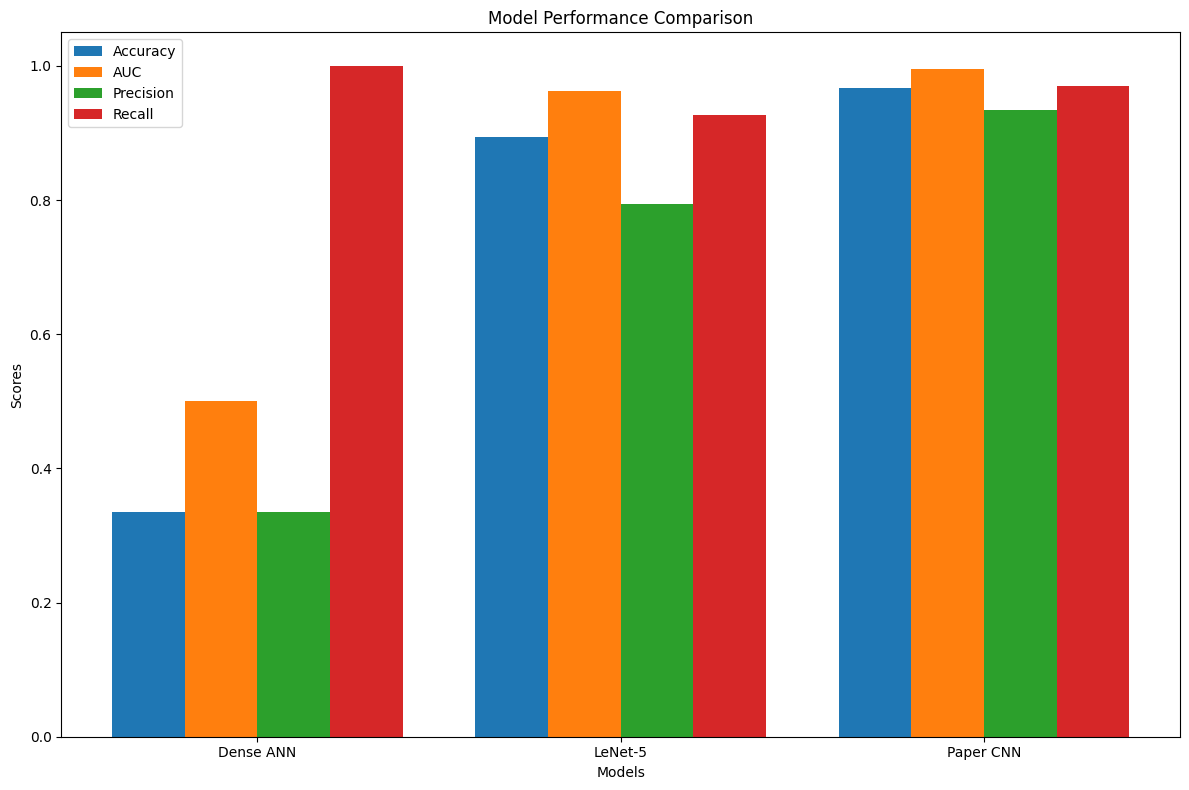

In [48]:
import matplotlib.pyplot as plt

models = ['Dense ANN', 'LeNet-5', 'Paper CNN']
accuracy = [test_metrics_dense['accuracy'], test_metrics_lenet['accuracy'], test_metrics_paper['accuracy']]
auc = [test_metrics_dense['auc'], test_metrics_lenet['auc'], test_metrics_paper['auc']]
precision = [test_metrics_dense['precision'], test_metrics_lenet['precision'], test_metrics_paper['precision']]
recall = [test_metrics_dense['recall'], test_metrics_lenet['recall'], test_metrics_paper['recall']]

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.2
index = np.arange(len(models))

bar1 = ax.bar(index, accuracy, bar_width, label='Accuracy')
bar2 = ax.bar(index + bar_width, auc, bar_width, label='AUC')
bar3 = ax.bar(index + 2*bar_width, precision, bar_width, label='Precision')
bar4 = ax.bar(index + 3*bar_width, recall, bar_width, label='Recall')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

#Used Sonnet 3.7 to help with designing this plot as I wanted to see all the metrics of the models in one place

In [49]:
best_model = best_paper_model 
best_model.save('final_best_model.h5')
print("Best model saved as 'final_best_model.h5'")

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Best model saved as 'final_best_model.h5'
